RAINSTORM

## Seize labels

- This notebook will help us visualize the results from labeled videos of an experiment

#### Requirements:

- The position files (processed by ``2-Prepare_positions``)
- The labels, geolabels or autolabels files (labeled by ``1-Behavioral_labeler``, ``3-Geometric_analysis`` or ``5-Automatic_analysis``)
- The movement files (processed by ``3-Geometric_analysis``)

---
#### Load the necessary modules

In [1]:
import os
import rainstorm.seize_labels as rst

---
#### 1. State your project path and experiment details in the params file
Define the path to the same folder used in `2-Prepare_positions`, and the path to the parameters file.

Go to the params.yaml file and specify the parameters in the *seize_labels* section.

In [2]:
base = r'C:\Users\dhers\Desktop\Rainstorm'
folder_path = r'C:\Users\dhers\Desktop\Rainstorm\docs\examples\Y_Maze'
folder_path = r'C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR'
params = os.path.join(folder_path, 'params.yaml')

---
#### 2. With the experiment details ready, we can create a reference file on our experiment folder.

We need to complete and use the reference file to tell the functions which groups and objects to use for each mouse.


In [3]:
reference_path = rst.create_reference_file(params)

Reference file already exists


#### Go to the experiment folder and complete the 'reference.csv' file
If you are using the NOR_example folder to try out rainstorm, you will find a copy of the reference file **already completed** inside the 'h5 files & others' folder.

All you need to do is move it to the experiment folder or copy its contents into the 'reference.csv' file.

Once you have completed the reference file, you can proceed to the next step where we will use it to create the 'summary' folder.

---
#### 3. Create the 'Summary' folder
This new folder will contain files for each video recording, which will be used to hold all the labels and geometric information.

The groups and objects on the ‘reference’ file will be used to organize the files into subfolders, and the object exploration columns will be renamed according to their role (e.g. Novel and Known).

In [4]:
# Lets rename the labels
summary_path = rst.create_summary(params)

Renamed and saved: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\summary\c57\Hab\03_2025-TORM_3xTR-R01_C1n-Hab_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\summary\c57\Hab\03_2025-TORM_3xTR-R02_C1i-Hab_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\summary\c57\Hab\03_2025-TORM_3xTR-R03_C1d-Hab_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\summary\c57\Hab\03_2025-TORM_3xTR-R04_C1a-Hab_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\summary\c57\Hab\03_2025-TORM_3xTR-R05_C2n-Hab_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\summary\c57\Hab\03_2025-TORM_3xTR-R06_C2i-Hab_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\summary\c57\Hab\03_2025-TORM_3xTR-R07_C2d-Hab_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\summary\c57\Hab\03_2025-TO

---
#### 4. With our files ready, all is left to do is to run the analysis and plot the results.

We can plot distance traveled, exploration for each object, freezing time, and more!

Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\plots\TS_multiple_analyses.png


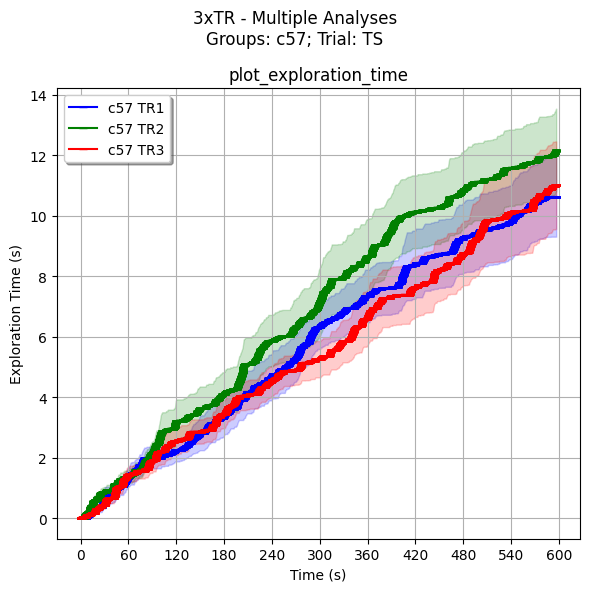

In [5]:
# rst.plot_multiple_analyses(params, trial='Y_Maze', plots=[rst.plot_alternations, rst.plot_roi_time])
# rst.plot_multiple_analyses(params, trial='Hab', plots=[rst.plot_exploration_time, rst.plot_exploration_boxplot, rst.plot_DI, rst.plot_exploration_scatterplot])
# rst.plot_multiple_analyses(params, trial='TR1', plots=[rst.plot_exploration_time, rst.plot_exploration_boxplot, rst.plot_DI, rst.plot_exploration_scatterplot])
# rst.plot_multiple_analyses(params, trial='TR2', plots=[rst.plot_exploration_time, rst.plot_exploration_boxplot, rst.plot_DI, rst.plot_exploration_scatterplot])
# rst.plot_multiple_analyses(params, trial='TR3', plots=[rst.plot_exploration_time, rst.plot_exploration_boxplot, rst.plot_DI, rst.plot_exploration_scatterplot])
rst.plot_multiple_analyses(params, trial='TS', plots=[rst.plot_exploration_time])

---
#### 5. Plot each mouse individually

After some user feedback, we decided to create plots for each mouse individually. This gives us the chance to evaluate if something is off, and spot any outliers on both training and testing sessions.

This feature is not yet fully implemented, as it only works properly if we have two objects on the arena. We will add support for more (or none) objects in the future.

You can test it with the demo data without problems, the plots will be stored in the example folder.

In [6]:
rst.plot_all_individual_exploration(params)

No data for target novelty found for trial Hab. Skipping.
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\plots\individual\03_2025-TORM_3xTR-R01_C1n-TR1.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\plots\individual\03_2025-TORM_3xTR-R02_C1i-TR1.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\plots\individual\03_2025-TORM_3xTR-R03_C1d-TR1.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\plots\individual\03_2025-TORM_3xTR-R04_C1a-TR1.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\plots\individual\03_2025-TORM_3xTR-R05_C2n-TR1.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\plots\individual\03_2025-TORM_3xTR-R06_C2i-TR1.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\plots\individual\03_2025-TORM_3xTR-R07_C2d-TR1.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\3xTR\plots\individual\03_2025-TORM_3xTR-R08_C2a-TR1.pn

---
---
#### These modular graphs are intended to show the dynamic behavior of mice, providing a deeper insight into what happens during learning and memory.

We have reached the end of this project. If you have read and followed the code up to this point, I want to thank you for your time and attention. If you have any questions and/or suggestions, do not hesitate to write me: sdhers@fbmc.fcen.uba.ar


---
RAINSTORM - Created on Jun 25, 2024 - @author: Santiago D'hers